In [23]:
import pandas as pd
import ray
import ray.tune
import matplotlib.pyplot as plt
import numpy as np
from ray import tune
from ray.tune import ExperimentAnalysis
pd.options.display.max_columns = None


In [29]:

analysis = ExperimentAnalysis("~/ray_results/q")
print(analysis.dataframe().columns)


Could not load trials from experiment checkpoint. This means your experiment checkpoint is likely faulty or incomplete, and you won't have access to all analysis methods. Observed error: Unknown trainable: train
Could not load trials from experiment checkpoint. This means your experiment checkpoint is likely faulty or incomplete, and you won't have access to all analysis methods. Observed error: Unknown trainable: train
Couldn't read config from 287 paths


Index(['loss', 'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore',
       'config/activation', 'config/batch_size', 'config/coupling_layers',
       'config/lr', 'config/lrdecay', 'config/network_layers',
       'config/network_nodes', 'config/opt', 'config/permute_soft',
       'config/wdecay', 'logdir'],
      dtype='object')


In [30]:
len(analysis.dataframe())


Could not load trials from experiment checkpoint. This means your experiment checkpoint is likely faulty or incomplete, and you won't have access to all analysis methods. Observed error: Unknown trainable: train
Couldn't read config from 287 paths


713

In [31]:
df=analysis.dataframe()
#df=df[columns]
df=df[df.loss==df.loss].sort_values("loss")
df.head(10)['logdir'].values

Could not load trials from experiment checkpoint. This means your experiment checkpoint is likely faulty or incomplete, and you won't have access to all analysis methods. Observed error: Unknown trainable: train
Couldn't read config from 287 paths


array(['/home/kaechben/ray_results/q/train_544ae_00013_13_activation=2.5991,coupling_layers=75,lr=0.00075166,network_layers=6,network_nodes=554_2022-01-23_19-50-31',
       '/home/kaechben/ray_results/q/train_544ae_00336_336_activation=2.0892,coupling_layers=43,lr=0.00097805,network_layers=6,network_nodes=593_2022-01-24_05-57-52',
       '/home/kaechben/ray_results/q/train_544ae_00606_606_activation=2.8892,coupling_layers=69,lr=0.00091325,network_layers=4,network_nodes=582_2022-01-24_13-58-13',
       '/home/kaechben/ray_results/q/train_544ae_00450_450_activation=2.6224,coupling_layers=57,lr=0.00098424,network_layers=6,network_nodes=459_2022-01-24_09-15-59',
       '/home/kaechben/ray_results/q/train_544ae_00116_116_activation=2.1155,coupling_layers=53,lr=0.00083447,network_layers=5,network_nodes=594_2022-01-23_22-57-06',
       '/home/kaechben/ray_results/q/train_544ae_00470_470_activation=2.4121,coupling_layers=50,lr=0.00091957,network_layers=6,network_nodes=476_2022-01-24_10-01-48',

In [28]:
#df=df[df["config/wasserstein"]]
columns=["loss","w1p","w1m","w1efp","config/activation","config/coupling_layers","config/lr","config/wasserstein"]

df[columns].sort_values('w1efp').head(20)

KeyError: "['w1p', 'w1m', 'w1efp', 'config/wasserstein'] not in index"

(array([ 1.,  0.,  2.,  1.,  2.,  1.,  7., 19., 79., 75.]),
 array([-2.84750422, -2.58429802, -2.32109182, -2.05788563, -1.79467943,
        -1.53147323, -1.26826703, -1.00506084, -0.74185464, -0.47864844,
        -0.21544224]),
 <BarContainer object of 10 artists>)

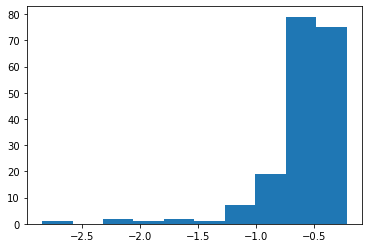

In [21]:
plt.hist(df[df["loss"]<0]["loss"])

In [31]:
from sklearn import ensemble 
import sklearn 
import numpy as np
from sklearn.inspection import permutation_importance
def fit_eval(df,na,y,plots="/home/kaechben/JetNet_NF/plots/"):
    col=y
    cols=["wdecay","activation","coupling_layers","lr","lrdecay","network_nodes","network_layers","permute_soft","wasserstein","wdecay"]

    #df=analysis.dataframe()
    df=df.rename(mapper=lambda x:x.split("/")[1] if x.find("/")>-1 else x ,axis=1)
    if na:
        df=df.dropna(subset=[y],axis=0)
        mask=y
        df=df[df[y]<100]
        train,test=sklearn.model_selection.train_test_split(df)
        y,y_t=train[y],test[y]
        X,X_t=train[cols],test[cols]
        gbm=ensemble.GradientBoostingRegressor(n_estimators=10000,validation_fraction=0.1,n_iter_no_change=10)
    else:
        df['isfinite']=0
        df.loc[df[y]==df[y],"isfinite"]=1
        df.loc[df[y]<10,"isfinite"]=1
        train,test=sklearn.model_selection.train_test_split(df)
        gbm=ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance',n_estimators=10000,validation_fraction=0.1,n_iter_no_change=10)
        mask='isfinite'
        y,y_t=train[mask],test[mask]
        X,X_t=train[cols],test[cols]
    

    
  
    plt.title('Distribution of {} {} in Train/Test'.format(mask,col))
    _,bins,_=plt.hist(y,alpha=0.3,label='train',bins=30 if na else 2 ,density=.5)
    plt.hist(y_t,alpha=0.3,label='test',bins=bins if na else 2,density=.5)
    plt.ylabel('Counts [A.U.]')
    plt.xlabel(col)
    plt.legend()
    plt.savefig(plots+"Dist_{}_{}.png".format(na,col))
    plt.close()
    gbm.fit(X,y)
    y_pred_t=gbm.predict(X_t)
    y_pred=gbm.predict(X)
    
    if not na:
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[1].set_title('Prediction Distribution in Classes for Test')
        ax[1].hist(y_pred_t[y_t==0],alpha=0.3,label='Truth NA',bins=30 if na else 2 ,density=1)
        ax[1].hist(y_pred_t[y_t==1],alpha=0.3,label='Truth finite',bins=30 if na else 2,density=1)
        ax[1].set_ylabel('Counts [A.U.]')
        ax[1].set_xlabel(mask)

        ax[1].legend()
        ax[0].set_title('Prediction Distribution in Classes for Train')
        ax[0].hist(y_pred[y==0],alpha=0.3,label='Truth NA',bins=30 if na else 2 ,density=1)
        ax[0].hist(y_pred[y==1],alpha=0.3,label='Truth finite',bins=30 if na else 2,density=1)
        ax[0].set_ylabel('Counts [A.U.]')
        ax[0].set_xlabel(mask)
        ax[0].legend()

        plt.savefig(plots+"Class_{}_{}.png".format(na,col))
        plt.close()
    test_deviance = np.zeros((gbm.n_estimators_), dtype=np.float64)

    for i, y_pred_s in enumerate(gbm.staged_predict(X_t)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = gbm.loss_(y_t, y_pred_s)
    plt.plot(gbm.train_score_,label='train')
    plt.plot(test_deviance,label='test')
    plt.title("GBM for {}".format(col))
    plt.ylabel('Loss (mse)' if na else 'Loss (deviance)')
    plt.xlabel('n_estimators')
    
    plt.legend()
    plt.savefig(plots+"Loss_{}_{}.png".format(na,col))
    
    plt.close()
    if na:
        print("Train R^2: ",gbm.score(X,y))
        print(r"Testing R^2: ",gbm.score(X_t,y_t))
   
    else:
        print("Train Accuracy: ",len(y_pred[y_pred==y])/len(y_pred))
        print("Test Accuracy: ",len(y_pred_t[y_pred_t==y_t])/len(y_pred_t))
    
    
    s=pd.Series(gbm.feature_importances_*100,index=X_t.columns)
    s.plot(kind='bar')
    plt.ylabel('Feature Importance in %')
    if na:
        plt.title('Feature Importances for {} with NA/inf excluded'.format(col))
    else:
        plt.title('Feature Importances in NA Classification of finite vs {} '.format(col))

    plt.savefig(plots+"FeatureImportances_{}_{}.png".format(na,col),bbox_inches='tight')
    plt.show()
    plt.close()


    
    r = permutation_importance(gbm, X_t, y_t,
                            n_repeats=30,
                            random_state=0)
    s=pd.Series(r.importances_mean*100,index=X_t.columns)
    serr=pd.Series(r.importances_std*100,index=X_t.columns)
    s.plot(kind='bar',yerr=serr)
    plt.ylabel('Feature Importance in %')
    plt.ylim(0,1.2*100*np.max(r.importances_mean))
    if na:
        plt.title('Feature Importances for {} with NA/inf excluded'.format(col))
    else:
        plt.title('Feature Importances in NA Classification of finite vs {} '.format(col))
    plt.savefig(plots+"RandomPermutationFeatureImportances_{}_{}.png".format(na,col),bbox_inches='tight')

    plt.show()

    for x,val in zip(s.index,s.values):
        if val>10:
            if x=="wasserstein":
                print("{} range: {} to {}".format(x,0,1))
            elif x=="lr":
                print("{} range: {} to {}".format(x,np.round(df[x].min(),4),np.round(df[x].max(),4)))
            else:
                print("{} range: {} to {}".format(x,int(df[x].min()),int(df[x].max())+1))
an=analysis.dataframe()

for reg in [False,True]:
    if not reg:
        print("class")
    else:
        print("reg")
    for metric in ['loss','w1p','w1efp']:
        print(metric+":")
        if metric=="loss":
        
            temp=an[an["w1p"]!=-1]
        else:
            temp=an[an[metric]!=-1]
        fit_eval(an,reg,metric)


Could not load trials from experiment checkpoint. This means your experiment checkpoint is likely faulty or incomplete, and you won't have access to all analysis methods. Observed error: Unknown trainable: train
Couldn't read config from 459 paths


class
loss:


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

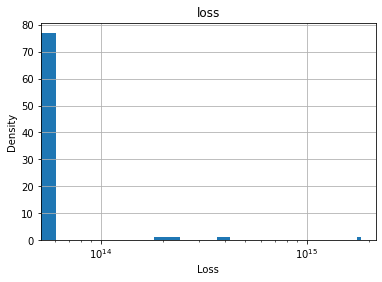

In [12]:
df.hist("loss",bins=30)
plt.xlabel('Loss')
plt.ylabel('Density')
plt.xscale('log')

In [22]:
df.sort_values('loss',ascending=True).head(30)[["trial_id","loss","config/activation","config/batch_size","config/coupling_layers",
                                             "config/lr","config/network_layers","config/network_nodes","config/permute_soft"]]

,trial_id,loss,config/activation,config/batch_size,config/coupling_layers,config/lr,config/network_layers,config/network_nodes,config/permute_soft
47,6b187_00011,-2.847504,2.080950,6000,78,0.000953,7,558,False
165,6b187_00128,-2.267612,2.557724,6000,53,0.000997,6,555,False
100,6b187_00143,-2.198779,2.816762,6000,67,0.000922,7,492,False
181,6b187_00142,-2.013334,2.896815,6000,76,0.000670,6,590,False
68,6b187_00152,-1.670115,2.706910,6000,57,0.000875,5,507,False
103,6b187_00016,-1.632964,2.181372,6000,75,0.000886,5,421,False
56,6b187_00097,-1.319349,2.938309,6000,52,0.000666,6,489,False
84,6b187_00099,-1.264438,2.223719,6000,31,0.000804,5,593,False
170,6b187_00045,-1.176340,2.430756,6000,75,0.000802,7,295,False
30,6b187_00125,-1.161711,2.582963,6000,59,0.000680,7,390,False


In [18]:
df.columns


Index(['loss', 'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore',
       'config/activation', 'config/batch_size', 'config/coupling_layers',
       'config/lr', 'config/network_layers', 'config/network_nodes',
       'config/permute_soft', 'config/point', 'logdir'],
      dtype='object')